<a href="https://colab.research.google.com/github/TillVollmer5/mass_spectroscopy/blob/main/Calibration_calculation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibration calculation
This skript aims to allow the calculation and generation of a linear regression to allow the quantivication of phthalates in the environement.

Input: The the peak list files (classic structure, header = 6, by thermofisher) are uploaded to the directory titeled *calibration_input*, it is of key importance that the title of the files follows the format: Cal_"conc.nr"_"series.nr"_"identification.nr"_pl.csv Any changes to filename, path or other changes that might impact the file significantly need to be comented and marked extensively.

The following code serves to import the librarys and mount the google drive. Additionally, the x-axis values, meaning the concentration values are imported and converted from a list containing only strings to a list containing a floats. The string section is used for the import of the files (input files do not contain ".") where the float version is used for formating, plotting and calculational actions. The x-axis values should be writen for each series and changed accordingly. The filname should be set as:
***x_values.csv***

In [ ]:
import numpy as np
from google.colab import drive
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import re

drive.mount('/content/drive', force_remount = True)

strings = []
with open('/content/drive/My Drive/calibration_input/x_values_3.csv', 'r') as file: #X-file needs to be created or addabted
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        strings.extend(row)

#Separating values and removing Nan if present
values = []
for string in strings:
    split_values = string.split(';')
    non_empty_values = [value for value in split_values if value.strip()]
    values.extend(non_empty_values)
values.reverse()

#Add decimals and save floats, this needs to be addapted depending on the concentrations present
values_float = []
for value in values:
    if value.startswith('0'):
        value_float = '0.' + value[1:]
    elif value.startswith('1'):
        value_float = '1.' + value[1:]
    else:
        value_float = value
    values_float.append(float(value_float))

print(strings)
print(values)
print(values_float)

Mounted at /content/drive
['4', '1996', '0998', '0499', '02495', '012475', '0062375', '00311876', '001559381']
['001559381', '00311876', '0062375', '012475', '02495', '0499', '0998', '1996', '4']
[0.01559381, 0.0311876, 0.062375, 0.12475, 0.2495, 0.499, 0.998, 1.996, 4.0]


This loop aims at importing the various files from the google drive, looping through each row (each row is one analyte or the internal standard) and saving them in a new file. This code requires the output variables (values) from the previous code section as well as the peak list files. The output specific in files for the row and concentration (repetition analysis number is removed) and saved in the output folder.

In [ ]:
for n in values:
    files = glob.glob(f'/content/drive/My Drive/calibration_input/Cal_{n}ug*.csv')

    if not files:
        print(f'Files matching pattern "Cal_{n}ug*.csv" were not found.')
        continue

    else:
        df = pd.read_csv(files[0], header=4)
        num_rows = len(df)
        for i in range(num_rows):
            row_dfs = []
            for file in files:
                df = pd.read_csv(file, header=4, na_values='', sep='[;,]', engine='python') #python engine used as regex operation leads to problems with c-engine, separators need to be adabted to delimiters present

                if i < len(df.index):
                    row = df.iloc[i, :].dropna().astype(str)
                    row_dfs.append(row)
                    #print(f"Row {i} extracted from {file}")
                else:
                    print(f"Index {i} is out of bounds for file {file}")

            combined_df = pd.concat(row_dfs, axis=1).T
            combined_df.to_csv(f"/content/drive/My Drive/calibration_output/Cal_{n}ug_ml_row{i+1}.csv", index=False, header=False, sep=';')

            formatted_row = '\t'.join(map(str, combined_df.values[0]))
            print(f"Files saved {file}")

Files saved /content/drive/My Drive/calibration_input/Cal_001559381ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_001559381ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_001559381ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_001559381ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_001559381ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_001559381ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_001559381ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_00311876ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_00311876ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_00311876ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_00311876ug_ml_3_3_5_pl.csv
Files saved /content/drive/My Drive/calibration_input/Cal_

The file contain the internal standard signal is used to take the ratio of the various signals and save the values in a new file. The file needs to be specified so that the internal standard signal correlates to the divisor name, so that this leads to the correct ratio. The first one calculates the ratio of the mean and the bottom one being used for the ratio of the standard deviation, although that might be insuficient and should be substituted by an appropriate error calculation (possibly gaussian errorpropagation).

In [ ]:
directory = '/content/drive/My Drive/calibration_output'

for n in (values):
    divisor_file = f'/content/drive/My Drive/calibration_output/Cal_{n}ug_ml_row3.csv' #Needs to be set to the row nr. of the peak list file containing the data of the internal standard
    divisor_df = pd.read_csv(divisor_file, sep=';', header=None)
    #print(f'divisor data: {divisor_df}')
    csv_files = glob.glob(os.path.join(directory, f"Cal_{n}ug_ml_*.csv"))

    for csv_file in csv_files:
        if csv_file == divisor_file:
            continue

        data_df = pd.read_csv(csv_file, sep=';', header=None)
        #print(f'compound data : {data_df}')
        data_df = data_df.apply(pd.to_numeric, errors='coerce')
        divided_data_df = pd.DataFrame()

        for i in range(len(data_df)):
          divided_row = data_df.iloc[i] / divisor_df.iloc[i]
          divided_data_df = divided_data_df.append(divided_row, ignore_index=True)

        new_file_name = os.path.splitext(csv_file)[0] + '_ratio.csv'
        #print(f'Divided data: {divided_data_df}')
        divided_data_df.to_csv(new_file_name, sep='\t', header=False, index=False)
        print(new_file_name)
        control_import_df = pd.read_csv(new_file_name, sep='\t', header=0)

        #Several control statements, use if nescessary
        """
        if control_import_df.equals(divided_data_df):
            print(f"The files match: {new_file_name}")
        else:
            print(f"The files do not match: {new_file_name}")

        print('control import:', control_import_df)
        print('calculated data:', divided_data_df)
        print('****************************************************************')

        """

<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f4

/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row2_ratio.csv
/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row4_ratio.csv
/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row7_ratio.csv
/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row2_ratio.csv
/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row4_ratio.csv
/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row7_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0062375ug_ml_row1_ratio.csv
/conten

<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f4

/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row2_ratio.csv
/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row4_ratio.csv
/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row7_ratio.csv
/content/drive/My Drive/calibration_output/Cal_02495ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_02495ug_ml_row2_ratio.csv
/content/drive/My Drive/calibration_output/Cal_02495ug_ml_row4_ratio.csv


<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f4

/content/drive/My Drive/calibration_output/Cal_02495ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_02495ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_02495ug_ml_row7_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0499ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0499ug_ml_row2_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0499ug_ml_row4_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0499ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0499ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0499ug_ml_row7_ratio.csv


<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f4

/content/drive/My Drive/calibration_output/Cal_0998ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0998ug_ml_row2_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0998ug_ml_row4_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0998ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0998ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_0998ug_ml_row7_ratio.csv
/content/drive/My Drive/calibration_output/Cal_1996ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_1996ug_ml_row2_ratio.csv


<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f4

/content/drive/My Drive/calibration_output/Cal_1996ug_ml_row4_ratio.csv
/content/drive/My Drive/calibration_output/Cal_1996ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_1996ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_1996ug_ml_row7_ratio.csv
/content/drive/My Drive/calibration_output/Cal_4ug_ml_row1_ratio.csv
/content/drive/My Drive/calibration_output/Cal_4ug_ml_row2_ratio.csv
/content/drive/My Drive/calibration_output/Cal_4ug_ml_row4_ratio.csv
/content/drive/My Drive/calibration_output/Cal_4ug_ml_row5_ratio.csv
/content/drive/My Drive/calibration_output/Cal_4ug_ml_row6_ratio.csv
/content/drive/My Drive/calibration_output/Cal_4ug_ml_row7_ratio.csv


<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f42>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  divided_data_df = divided_data_df.append(divided_row, ignore_index=True)
<ipython-input-3-2eb6a1314f4

The following code allows to fit a linear function to the datasets present for each compound. The files with the tag "_ratio" are required in adition to the concentration values for the x-axis (from the first code sequence of the notebook). The output of this script is saved in the export folder of the google drive and contains the intercept, the slope and the R2 value of a fitted function.

Output file:

***Cal_{n}_analyte_linreg.csv***

In [ ]:
#Define the amount of rows present, addapt if nescessary
comp_1 = 1
comp_fin = 8

for n in range(comp_1, comp_fin):
    if n == 3:  #Skip the data of the internal standard, needs to be adapted
        continue

    files = glob.glob(f'/content/drive/My Drive/calibration_output/Cal_*ug_ml_row{n}*_ratio.csv')
    print(files)

    xy_pairs = []

    for i, file in enumerate(files):
        y_data = pd.read_csv(file, header=None, sep='\t')
        #print('Y data:', y_data.iloc[0:, 3])
        if not y_data.empty:
            if y_data.shape[1] >= 4:
                x_val = values_float[i]
                y_vals = y_data.iloc[0:, 3].to_numpy()
                for y in y_vals:
                    xy_pairs.append((x_val, y))
            else:
                print(f"DataFrame does not have the fourth column: {file}")
        else:
            print(f"Empty DataFrame: {file}")

    x_values = np.array([pair[0] for pair in xy_pairs]).reshape(-1, 1)
    y_values = np.array([pair[1] for pair in xy_pairs])

    #print('x values:', x_values)
    #print('y values:', y_values)

    model = LinearRegression()
    model.fit(x_values, y_values)
    x_pred = model.predict(x_values)
    r2 = r2_score(y_values, x_pred)

    intercept = model.intercept_
    slope = model.coef_

    output_file = f"/content/drive/My Drive/calibration_export/Cal_{n}_analyte_linreg.csv"
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Intercept", "Slope", "R2 Value"])
        writer.writerow([intercept, slope, r2])

    #For debugging, use to get more information
    """print('intercept:', intercept)
    print('slope:', slope)
    print('R^2:', r2)
    print("Output saved to:", output_file)"""

['/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0062375ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_02495ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0499ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0998ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_1996ug_ml_row1_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_4ug_ml_row1_ratio.csv']
['/content/drive/My Drive/calibration_output/Cal_001559381ug_ml_row2_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_00311876ug_ml_row2_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_0062375ug_ml_row2_ratio.csv', '/content/drive/My Drive/calibration_output/Cal_012475ug_ml_row2_ratio.csv

The following script creates a plot of the chromatogram peak area ratio of the analytes and the internal standard and the corresponding concentration. For this reason the output files for the various rows (analyte) for the previous code sequence are nescessary, as well as the variable containing the list of the concentration values (from the first section of code of this notebook). One diagram is created for one row/analyte and saved in the export folder on the google drive as a pdf. The file only contains the various data points, not the linear function, which could be implemented knowing the data from a later code sequence in this notebook. Additionally, the designe of the plots was keept minimalistic and simple, which could be changed at a later date.

Output file:

***Cal_{n}_analyte_calibration_curve.pdf***

[0.01559381, 0.0311876, 0.062375, 0.12475, 0.2495, 0.499, 0.998, 1.996, 4.0]
[[0.0036786349135054, 0.0036509221555723, 0.0036079271276514, 0.0042038726242997, 0.0040770256199231, 0.0040749330931072], [0.0070437175573029, 0.0069481236616159, 0.0069063475796226, 0.0089972276537422, 0.0088738890999931, 0.0089315900192714], [0.0144575833118771, 0.0144333431375564, 0.014059141399706, 0.0173305018848684, 0.017142777658113, 0.0167937311615073], [0.0333897865976889, 0.0323720315998541, 0.0328099747161948, 0.0238930502946836, 0.0238212103757278, 0.0239883652697145], [0.0647887716289265, 0.0622271385347519, 0.0620320708290223, 0.0637064901359111, 0.0638741258150004, 0.0623413154615128], [0.1325401799539255, 0.126705219502978, 0.1283074932105923, 0.1423915246777579, 0.1394652752237682, 0.141902313803883], [0.2636609434462688, 0.2509074579100765, 0.2543835565571252, 0.3061039705571144, 0.2983816626022991, 0.3024211201046113], [0.5138191096744632, 0.506871473939724, 0.5109798100978273, 0.6892633275

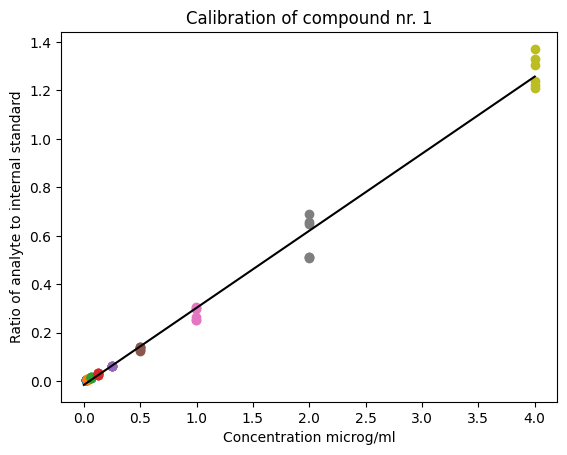

[0.01559381, 0.0311876, 0.062375, 0.12475, 0.2495, 0.499, 0.998, 1.996, 4.0]
[[0.0036677528888242, 0.0036401061913316, 0.0035422637868409, 0.0042924417026183, 0.0042239380955269, 0.0040077407623141], [0.0070246306792236, 0.007018344021031, 0.0069441037881636, 0.0091211267452298, 0.0089021812792186, 0.0088884832515193], [0.0147854644210906, 0.0144886250269655, 0.0143010068729488, 0.0175099615569064, 0.0173742674807199, 0.0170045080272817], [0.03531015027495, 0.033576899923361, 0.0336823905773452, 0.0253794946368113, 0.0251079142876785, 0.025113654337801], [0.0694861951965102, 0.0639263512095092, 0.0665415100519087, 0.0666560048387389, 0.0670941227199882, 0.0677870187286728], [0.1428523767639399, 0.1349436639458598, 0.1406266015240191, 0.1541353671957668, 0.1507162018514677, 0.1496237208159918], [0.2887463254405971, 0.2782376607802821, 0.2786313822398142, 0.3343496285325546, 0.3298918242964377, 0.3323703716553029], [0.5680126655911448, 0.5632259977948115, 0.5638841861210258, 0.7431244773

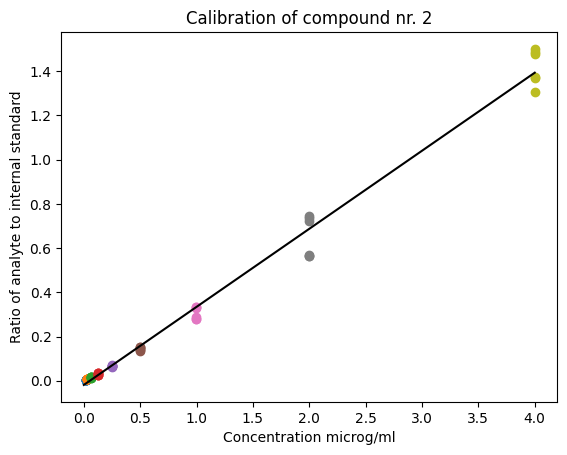

[0.01559381, 0.0311876, 0.062375, 0.12475, 0.2495, 0.499, 0.998, 1.996, 4.0]
[[0.0044347868824566, 0.0044365094325151, 0.0044091056405307, 0.0051286714820379, 0.0050657127852029, 0.0049684795022127], [0.008837453186936, 0.0088309318302592, 0.0087203424876938, 0.0112295809650038, 0.0114041823823651, 0.0113973438039717], [0.0190146844247778, 0.0192824020295129, 0.0191137220664437, 0.0228673031138973, 0.0229378821523486, 0.0233158341690241], [0.0478758254209795, 0.0476200680582285, 0.0477612625673529, 0.0356819097626551, 0.0356728662934341, 0.0358183535469091], [0.1016073102033266, 0.0971252638262449, 0.0976617595500101, 0.099086794066077, 0.099702350395028, 0.0990614043279426], [0.2170969557819044, 0.2161155836471483, 0.2138126789403958, 0.24122438571976, 0.2367736463261057, 0.2376875679362889], [0.4546829675421144, 0.4499677300202896, 0.4536815508148366, 0.5363052139066327, 0.5414316099369539, 0.5513536810230556], [0.9359925136093158, 0.9488969279622268, 0.9587037574844391, 1.2396336308

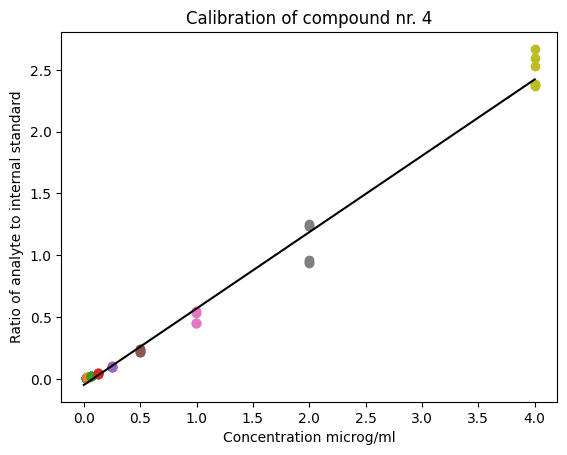

[0.01559381, 0.0311876, 0.062375, 0.12475, 0.2495, 0.499, 0.998, 1.996, 4.0]
[[0.0014767275896524, 0.0014964426828311, 0.0014338643243771, 0.0016777557195537, 0.0016408429675664, 0.0015661263326351], [0.0029817516716353, 0.0030298158217097, 0.002940574778403, 0.0038728201948992, 0.0037502362168429, 0.0037715956101605], [0.0067257230758881, 0.006776247455117, 0.0067781356246421, 0.0080546117306251, 0.0079448140882974, 0.0078209921114826], [0.0176776138419261, 0.0170287506752857, 0.0173149649736826, 0.0131483935388721, 0.0127816905524342, 0.0125886961397281], [0.0389270990102856, 0.0378134749953637, 0.037569365388272, 0.0380985137937013, 0.0380995210558034, 0.0374079772762966], [0.0877244727919064, 0.0847667578615144, 0.0855305150500803, 0.0946404522753788, 0.0919310797460195, 0.09125959582344], [0.189907058773829, 0.1829538166826234, 0.1854898966673435, 0.2198675429723698, 0.2219538414676286, 0.2190840388579484], [0.415750654814825, 0.4113711333479476, 0.4100614834262027, 0.531613374094

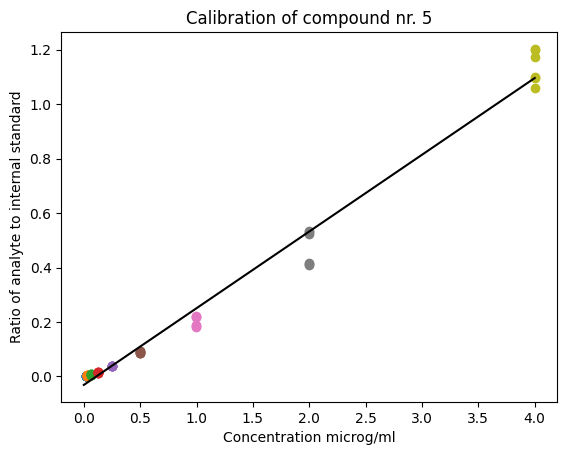

[0.01559381, 0.0311876, 0.062375, 0.12475, 0.2495, 0.499, 0.998, 1.996, 4.0]
[[0.0023168192306957, 0.0023519967892886, 0.0022824808573883, 0.0026307188405816, 0.0025155646058865, 0.0025035366937688], [0.004604443912379, 0.0047079541817923, 0.0045648689069482, 0.0061742457361413, 0.0059335945888194, 0.0058103858467001], [0.0103267027645095, 0.0104590398707264, 0.0101342098647626, 0.0121654581332897, 0.0122883597771465, 0.0121118235101047], [0.0266358144565521, 0.0268537639325622, 0.0266976838538418, 0.0200789826566932, 0.019762590133406, 0.0193229567387279], [0.0618037344994126, 0.0594102260786413, 0.05999251199558, 0.0591552639935673, 0.0588462425661968, 0.0584980619859959], [0.1380570383752513, 0.1374082371915923, 0.1376286353786984, 0.1523500923119553, 0.1508365205496865, 0.1469908624301444], [0.3073903754957979, 0.3041732009821747, 0.3070674628887641, 0.3568770926779345, 0.3687001234135217, 0.3681257691378294], [0.6819951340849463, 0.6862015101249671, 0.6923165469850473, 0.865235523

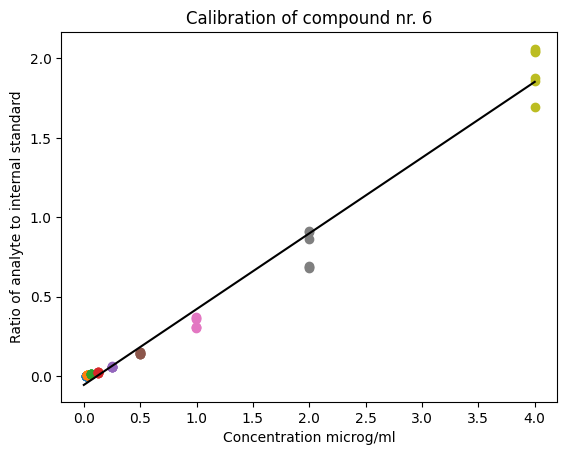

[0.01559381, 0.0311876, 0.062375, 0.12475, 0.2495, 0.499, 0.998, 1.996, 4.0]
[[0.0022653593444572, 0.0022903826348616, 0.0022248740236685, 0.0024440943199634, 0.0023422796078642, 0.0022814939676377], [0.0044816909453712, 0.0046036577644855, 0.004450441638711, 0.005726646440705, 0.005652607647264, 0.0055225644126016], [0.0102341433199442, 0.0101025707585543, 0.0101470245686071, 0.0118072248299912, 0.011631029040721, 0.0118384232045367], [0.0263611213163025, 0.0260925486926057, 0.0262904370799835, 0.0193821167550098, 0.0188372555300786, 0.0184413968885012], [0.0631980569071777, 0.0601588992560021, 0.0592818772323811, 0.0588804742967603, 0.0585126304377957, 0.0578706760359483], [0.1510493020456068, 0.1461032754318359, 0.1449459982019483, 0.1602549646589287, 0.1554787233051847, 0.1507063832587244], [0.3448988644664557, 0.3342344486632929, 0.3344988759519618, 0.3823001407429655, 0.3974848600868735, 0.3925020836086372], [0.7904886987016397, 0.7805470661689667, 0.7726368430087289, 0.964504641

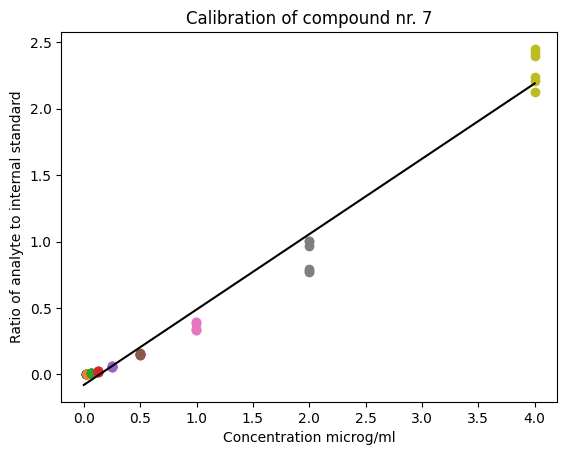

In [ ]:
for n in range(comp_1, comp_fin):
    files = glob.glob(f'/content/drive/My Drive/calibration_output/Cal_*ug_ml_row{n}*_ratio.csv')

    if n == 3: #The internal standard row is skipped, needs to be adabted
      continue

    y_values = []

    for file in files:
        y_data = pd.read_csv(file, header=None, sep='\t')
        #print(y_data.head())
        if not y_data.empty:
            if y_data.shape[1] >= 4:
                y_values.append(y_data.iloc[:, 3].tolist())
            else:
                print(f"DataFrame does not have the fourth column: {file}")
        else:
            print(f"Empty DataFrame: {file}")

    print(values_float)
    print(y_values)

    fig, ax = plt.subplots()

    for i, y_set in enumerate(y_values):
      x_values = [values_float[i]] * len(y_set)
      ax.scatter(x_values, y_set, label=f"Set {i+1}")

    function = pd.read_csv(f'/content/drive/My Drive/calibration_export/Cal_{n}_analyte_linreg.csv', header=0)
    print(function)
    slope_str = function.iloc[0, 1]
    slope_str = slope_str.strip('[]')
    slope = float(slope_str)
    intercept = function.iloc[0, 0]
    x_line = np.linspace(0, values_float[8])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color='black')

    ax.set_xlabel("Concentration microg/ml")
    ax.set_ylabel("Ratio of analyte to internal standard")
    ax.set_title(f"Calibration of compound nr. {n}")

    plt.savefig(f"/content/drive/My Drive/calibration_export/Cal_{n}_analyte_calibration_curve_1.pdf")
    plt.show()